# Exploring the Monodromic Quintessence model

In this notebook, I try to reproduce some figures from https://arxiv.org/pdf/1709.01544.pdf. I will refer to equations and figures in the paper.

Author: João Victor Rebouças, March 2024

In [7]:
from copy import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Units: assume reduced natural units: $c = 8 \pi G = \hbar = 1$

In [2]:
# Value of rho_cr from https://pdg.lbl.gov/2015/reviews/rpp2015-rev-astrophysical-constants.pdf
# TODO: the units seem to be a bit off in Figure 2a
rho_cr_over_h2_in_gev4 = 1.053e-5 / (8065.544e9)**3

# Fixed parameters
h = 0.6756
omega_m = 0.27
omega_phot = 2.47e-5/h**2
omega_massless_nu = 3*(7/8)*(4/11)**(4/3)*omega_phot
omega_r = omega_phot + omega_massless_nu
omega_de = 1 - omega_m - omega_r

rho_cr = 3

## Equations:
The Klein-Gordon equation for $\phi$ with DM interaction is (see Equation 39):

$\phi'' + 2\mathcal{H}\phi' = -\frac{a^2\rho_\chi}{\phi}$

The idea is to split the second-order equation for $\phi$ into two first-order equations for $\phi$ and $\phi'$, with the independent variable being the scale factor $a$. We use the relation

$\frac{d}{d\tau} = \frac{da}{d\tau}\frac{d}{da} = a\mathcal{H}\frac{d}{da}$

to rewrite the Klein-Gordon equation as:

$\frac{d\phi}{da} = \frac{\phi'}{a\mathcal{H}}$

$\frac{d\phi'}{da} = -2\frac{\phi'}{a} - \frac{a\rho_\chi}{\mathcal{H}\phi}$

In [105]:
class Params:
	def __init__(self, C=rho_cr, A=0.05, alpha=0.2, nu=50):
		self.C = C
		self.A = A
		self.alpha = alpha
		self.nu = nu
	def __repr__(self):
		return f"C = {self.C}; alpha = {self.alpha}; A = {self.A}; nu = {self.nu}"

def V(phi: float, p: Params):
	return p.C*phi**(-p.alpha)*(1 - p.A*np.sin(p.nu*phi))

def V_derivative(phi: float, p: Params):
	return p.C*(-p.alpha*phi**(-p.alpha-1)*(1 - p.A*np.sin(p.nu*phi)) - phi**(-p.alpha)*p.A*p.nu*np.cos(p.nu*phi))

def H_curly(y: list[float], a: float, p: Params) -> float:
	phi, phi_prime = y
	rho_phi = phi_prime**2/(2*a**2) + V(phi, p)
	rho = rho_cr*(omega_r*a**(-4) + omega_m*a**(-3)) + rho_phi
	return a*np.sqrt(rho/3)

def equations(y: list[float], a: float, p: Params) -> list[float]:
	phi, phi_prime = y
	H = H_curly(y, a, p)
	dphi = phi_prime/(a*H)
	dphi_prime = -2*phi_prime/a - a*V_derivative(phi, p)/H
	return np.array([dphi, dphi_prime])

def equations_loga(y: list[float], loga: float, p: Params) -> list[float]:
	a = np.exp(loga)
	derivs = equations(y, a, p)
	return a*derivs

def integrate_cosmo(ic: list[float], a_ini: float, a_end: float, n_steps: int, p: Params) -> list[list[float], list[float]]:
	# Integrates first with respect to log(a)
	frac = 0.4 # The user provides the total number of time steps, `frac` is the fraction of time-steps spent in log integration
	a_treshold = 1e-3 # Scale factor to switch between log integration and normal integration
	n_steps_log = int(frac*n_steps)
	a_log = np.logspace(np.log10(a_ini), np.log10(a_treshold), n_steps_log)
	loga = np.log(a_log)
	result_log = odeint(equations_loga, ic, loga, args=(p,))
	ic_normal_integration = result_log[-1] # Initial conditions of normal integration is final state of log integration
	a = np.linspace(a_treshold, a_end, n_steps-n_steps_log)
	result_normal = odeint(equations, ic_normal_integration, a, args=(p,))
	return np.concatenate((a_log, a)), np.concatenate((result_log, result_normal))

def find_omega_de_0(result, p: Params):
	phi, phi_prime = result.T
	rho_phi_0 = phi_prime[-1]**2/2 + V(phi[-1], p)
	rho_tot_0 = rho_cr*(omega_r + omega_m) + rho_phi_0
	return rho_phi_0/rho_cr

def get_initial_phi(a_ini, pars):
	H_ini = 100*h*np.sqrt(omega_m*a_ini**(-3) + omega_r*a_ini**(-4))
	t_ini = 1/(2*H_ini)
	p = 2/(2 + pars.alpha)
	phi_tilde_0 = ((p**2 + p)/(pars.alpha*pars.C))**(-1/(2+pars.alpha))
	phi_i = phi_tilde_0 * t_ini**p
	return phi_i

def solve_system(a_ini, a_end, n_steps, p):
	print("-----")
	print(f"Begin shooting for C")
	print(f"Target omega_de: {omega_de:.6f}")

	# Initial guesses for shooting parameters
	C_1 = 1.15*rho_cr*omega_de
	C_2 = 0.9*rho_cr*omega_de
	p_1 = copy(p)
	p_2 = copy(p)
	p_1.C = C_1
	p_2.C = C_2
	
	ic = [0, 0]
	# Integrate KG with initial guesses
	ic[0] = get_initial_phi(a_ini, p_1)
	a, result_1 = integrate_cosmo(ic, a_ini, a_end, n_steps, p_1)
	ic[0] = get_initial_phi(a_ini, p_2)
	a, result_2 = integrate_cosmo(ic, a_ini, a_end, n_steps, p_2)	

	omega_de_1 = find_omega_de_0(result_1, p_1)
	omega_de_2 = find_omega_de_0(result_2, p_2)
	
	# Assess errors at initial guesses
	error_de_1 = (omega_de_1 - omega_de)/omega_de
	error_de_2 = (omega_de_2 - omega_de)/omega_de

	print(f"C = {C_1:.6f} => omega_de = {omega_de_1:.6f} (error = {error_de_1:.6f})")
	print(f"C = {C_2:.6f} => omega_de = {omega_de_2:.6f} (error = {error_de_2:.6f})")

	# TODO: Secant method does not require initial guesses to enclose solution
	encapsulating = (omega_de_1 - omega_de)*(omega_de_2 - omega_de) < 0
	if not encapsulating:
		print("WARNING: initial guesses for V0 did not encapsulate the target omega_de")
		print(f"  Target omega_de: {omega_de}")
		print(f"  C = {C_1:.6f} => omega_de = {omega_de_1:.6f}")
		print(f"  C = {C_2:.6f} => omega_de = {omega_de_2:.6f}")
	
	iters = 0
	max_iters = 20
	while (iters < max_iters):
		iters += 1

		# Fit a line between (C_1, omega_de_1) and (C_2, omega_de_2)
		a_line = (omega_de_2 - omega_de_1)/(C_2 - C_1)
		b_line = omega_de_2 - a_line*C_2

		# Choose the point where the line would cross the target omega_de
		C_try = (omega_de - b_line)/a_line
		p.C = C_try
		ic[0] = get_initial_phi(a_ini, p)

		# Integrate KG assuming this new V0
		a, result_try = integrate_cosmo(ic, a_ini, a_end, n_steps, p)
		
		# Evaluate omega_de for new point
		omega_de_try = find_omega_de_0(result_try, p)
		
		# Assess errors at new point
		error = (omega_de_try - omega_de)/omega_de
		print(f"C = {C_try:.6f} => omega_de = {omega_de_try:.6f} (error = {error:.6f})")
		
		# Exit condition
		if abs(error) < 1e-4: break

		# Substitute one of the initial C guesses by the new C guess
		if (omega_de_try > omega_de):
			C_1 = C_try
			omega_de_1 = omega_de_try
		else:
			C_2 = C_try
			omega_de_2 = omega_de_try
		
	if error > 1e-4:
		print(f"WARNING: reached max iterations in shooting with error = {error}")
	else:
		print(f"Finished shooting successfully after {iters} iterations")
	return a, result_try

In [126]:
# Getting results
a_ini = 1e-5
n_steps = 10_000

cases = [
	Params(A=0),
	Params(A=0.1, nu=50),
	Params(A=0.05, nu=200),
	Params(A=0.05, nu=50),
]
results = []
for case in cases:
	a, result = solve_system(a_ini, 1, n_steps, case)
	results.append(result)

-----
Begin shooting for C
Target omega_de: 0.729909
C = 2.518186 => omega_de = 0.996340 (error = 0.365019)
C = 1.970754 => omega_de = 0.790964 (error = 0.083647)
  Target omega_de: 0.7299090152606962
  C = 2.518186 => omega_de = 0.996340
  C = 1.970754 => omega_de = 0.790964
C = 1.808012 => omega_de = 0.729441 (error = -0.000642)
C = 1.809259 => omega_de = 0.729913 (error = 0.000005)
Finished shooting successfully after 2 iterations
-----
Begin shooting for C
Target omega_de: 0.729909
C = 2.518186 => omega_de = 1.436574 (error = 0.968155)
C = 1.970754 => omega_de = 1.124294 (error = 0.540320)
  Target omega_de: 0.7299090152606962
  C = 2.518186 => omega_de = 1.436574
  C = 1.970754 => omega_de = 1.124294
C = 1.279393 => omega_de = 0.729904 (error = -0.000007)
Finished shooting successfully after 1 iterations
-----
Begin shooting for C
Target omega_de: 0.729909
C = 2.518186 => omega_de = 1.048949 (error = 0.437095)
C = 1.970754 => omega_de = 0.827715 (error = 0.133997)
  Target omega_d

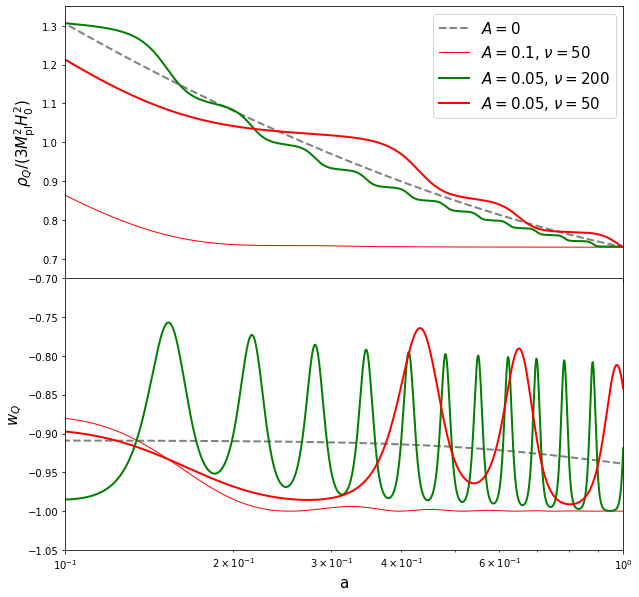

In [142]:
# Calculating densities for each case
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10), gridspec_kw={'hspace': 0})
rho_r_a = rho_cr* omega_r * a**(-4)
rho_m_a = rho_cr* omega_m * a**(-3)
lws = [2, 1, 2, 2]
lss = ['--', '-', '-', '-']
colors = ['gray', 'red', 'green', 'red']
legend_labels = [r"$A = 0$", r"$A = 0.1$, $\nu = 50$", r"$A = 0.05$, $\nu = 200$", r"$A = 0.05$, $\nu = 50$"]
for case, result, lw, ls, color, label in zip(cases, results, lws, lss, colors, legend_labels):
	phi, phi_prime = result.T
	rho_de_a = phi_prime**2/(2*a**2) + V(phi, case)
	w_de_a = (phi_prime**2/(2*a**2) - V(phi, case))/rho_de_a
	rho_de_a_lcdm = rho_cr*(1-omega_m-omega_r)*np.ones((n_steps))
	axs[0].semilogx(a, rho_de_a/rho_cr, color=color, ls=ls, lw=lw, label=label)
	axs[1].semilogx(a, w_de_a, color=color, ls=ls, lw=lw, label=label)

axs[0].set_ylabel(r"$\rho_Q/(3M^2_\mathrm{pl}H_0^2)$", fontsize=15)
axs[0].set_ylim([0.65, 1.35])
axs[1].set_ylabel(r"$w_Q$", fontsize=15)
axs[1].set_ylim([-1.05, -0.7])
axs[0].set_xlim([0.1, 1])
axs[1].set_xlabel(r"a", fontsize=15)
axs[0].legend(loc="upper right", fontsize=15)
plt.savefig("monodromic_quintessence_reproduction.pdf")